In [ ]:
#| default_exp stats

# stats -- Working with the data

> A simple package for analyzing pklmart data

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *
import pandas as pd
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')

In [ ]:
#| export
from pklshop.data import *

In [179]:
table_names

['tournament',
 'match',
 'game',
 'rally',
 'shot_type_ref',
 'shot',
 'player',
 'team']

In [181]:
#| export
rally = get_tab_as_df("rally")
players = get_tab_as_df("player")
game = get_tab_as_df("game")
team = get_tab_as_df("team")
match = get_tab_as_df("match")
tournament = get_tab_as_df("tournament") 

Here are some useful functions for analyzing a given game. Let's start by finding out which team served first

In [ ]:
#| export
def get_first_serve_team(game_id: str):
    '''
    Returns the team_id of the team that served first for a given game with game_id.
    '''
    return rally[(rally.game_id == game_id) & (rally.rally_nbr == 1)].srv_team_id.values[0]

In [ ]:
game_id_test = 'G1'
get_first_serve_team(game_id_test)

'T1'

This returned the team ID. But I'm curious what the names of the players are. To do that, let's write a function that looks at the `players` table.

In [ ]:
#| export
def get_team_names(team_id: str):
    '''
    Returns the name of the team with team_id
    '''
    return team[team.team_id == team_id].team_nm.values[0]

In [ ]:
first_srv_team_id = get_first_serve_team(game_id_test)
get_team_names(first_srv_team_id)

'Jesse Irvine & Catherine Parenteau'

Now let's write a function that gives a more complete summary of a game

In [ ]:
#| export
def get_team_ids(game_id: str):
    '''
    Returns the team_ids of the teams that played a given game with game_id with the winning
    team returned first
    '''
    return game[game.game_id == game_id].w_team_id.values[0], game[game.game_id == game_id].l_team_id.values[0]
    
def summarize_game(game_id: str):
    w_team_id, l_team_id = get_team_ids(game_id_test)
    w_team_nm, l_team_nm = get_team_names(w_team_id), get_team_names(l_team_id)
    w_team_score, l_team_score = game[game.game_id == game_id].score_w.values[0], game[game.game_id == game_id].score_l.values[0]
    print(f"{w_team_nm} beat {l_team_nm} in game {game_id} by a score of {w_team_score} to {l_team_score}")

In [ ]:
summarize_game(game_id_test)

Anna Leigh Waters & Leigh Waters beat Jesse Irvine & Catherine Parenteau in game G1 by a score of 12 to 10


Now let's look at some overall statsitics we can get from the data.

In [ ]:
#| export
def team_first_serve_win_frac(team_id):
    '''
    Takes a team id and returns that team's first serve win percentage.
    '''
    # Get all rallies where the team served the first rally of the game
    rally_fs_df = rally[(rally.rally_nbr == 1) & (rally.srv_team_id == team_id)]
    num_first_serves = len(rally_fs_df)
    #Find the number of games won by the team when they served first
    num_first_serve_games_won = sum(game[game.game_id.isin(rally_fs_df.game_id)].w_team_id == team_id)
    if num_first_serves == 0:
        return 0
    else:
        return num_first_serve_games_won/num_first_serves

In [ ]:
team_id_test = 'T2'
team_win_frac_test = team_first_serve_win_frac(team_id_test)
print("{} won {:.2f}% of games where they served first".format(get_team_names(team_id_test), team_win_frac_test*100))

Anna Leigh Waters & Leigh Waters won 33.33% of games where they served first


Let's now look at all the games in the database and sort the teams by their win percentage when serving first.

In [ ]:
fs_win_frac = [team_first_serve_win_frac(team_id) for team_id in team.team_id]
team['fs_win_frac'] = fs_win_frac
team.sort_values('fs_win_frac', ascending=False).head()

,team_id,player_id,player_seq_nbr,team_nm,maint_dtm,maint_app,create_dtm,create_app,fs_win_frac
76,T39,P61,1,Gizmo Hall & David McNally,2022-10-20 22:42:52.072401+00:00,postgres,2022-10-20 22:42:52.072401+00:00,postgres,1.0
19,T10,P18,2,Greg Dow & Anderson Scarpa,2022-07-28 21:21:24.377249+00:00,postgres,2022-07-28 21:21:24.377249+00:00,postgres,1.0
21,T11,P20,2,Chrissy Penfold & Eli Powell,2022-08-03 02:10:17.304370+00:00,postgres,2022-08-03 02:10:17.304370+00:00,postgres,1.0
79,T40,P63,2,Ryan Kane & Brandon Ward,2022-10-20 22:42:52.079848+00:00,postgres,2022-10-20 22:42:52.079848+00:00,postgres,1.0
24,T13,P23,1,Collin Johns & Ben Johns,2022-08-08 03:10:56.810337+00:00,postgres,2022-08-08 03:10:56.810337+00:00,postgres,1.0


Lastly, let's look at the win percentage when serving first, marginalized over all games

In [ ]:
#| export
def get_frac_first_serve_wins(game_df):
    '''
    Returns the fraction of games won by the first searver for a given df of games.
    '''
    count = 0
    for game_id in game_df.game_id:
        if (game_df[game_df.game_id == game_id].w_team_id == get_first_serve_team(game_id)).values[0]:
            count +=1 
    return count/len(game_df)

In [ ]:
first_serve_win_frac = get_frac_first_serve_wins(game)
print("The first serving team won {:.2f}% of games".format(first_serve_win_frac*100))


The first serving team won 54.90% of games


Let's see how Ben Johns compares to the average

In [ ]:
#| export
def get_player_id_from_name(player_name: str):
    '''
    Returns the player_id of a player with player_name.
    '''
    first, last = player_name.split(' ')[0], player_name.split(' ')[1]
    name_mask = (players.first_nm.str.lower() == first.lower()) & (players.last_nm.str.lower() == last.lower())
    if max(name_mask) == False:
        print("Player not found")
        return None
    else:
        return players[name_mask].player_id.values[0]

def get_teams_from_player(player_id: str):
    '''
    Returns the team_ids of the teams that a player with player_id played for.
    '''
    return team[team.player_id == player_id].team_id.values

In [ ]:
player_name_test = "Ben Johns"
player_id_test = get_player_id_from_name(player_name_test)

In [ ]:
#Find the teams that Ben Johns played for
team_ids_test = get_teams_from_player(player_id_test)
for team_id in team_ids_test:
    print(get_team_names(team_id))

Collin Johns & Ben Johns
Ben Johns & Tyler Loong


In [ ]:
#| export
def games_played_by_team(team_id):
    '''
    Returns the number of games played by a team with team_id.
    '''
    return len(game[(game.w_team_id == team_id) | (game.l_team_id == team_id)])

In [ ]:
net_games_played = sum([games_played_by_team(team_id) for team_id in team_ids_test]) #Number of games played by Ben Johns on any team
avg_first_serve_win_frac_test = sum([team_first_serve_win_frac(team_id)* games_played_by_team(team_id) for team_id in team_ids_test])/net_games_played #Average first serve win frac for Ben Johns
print("{}'s average first serve win percentage is {:.2f}%".format(player_name_test, avg_first_serve_win_frac_test*100))

Ben Johns's average first serve win percentage is 83.33%


In [ ]:
colors = sns.color_palette('pastel')

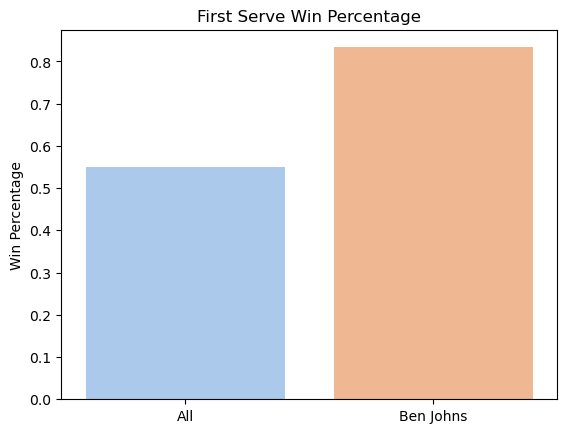

In [ ]:
sns.barplot(x=['All', player_name_test ], y=[first_serve_win_frac, avg_first_serve_win_frac_test], palette=colors)
plt.title("First Serve Win Percentage")
plt.ylabel("Win Percentage")
# plt.savefig('figures/first_serve_win_percentage.pdf')
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()